In [2]:
import pandas as pd

bbbp_df = pd.read_csv("data/raw/BBBP.csv")

# Preview the dataset
print(bbbp_df.shape)
print(bbbp_df.head())

(2050, 4)
   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  


In [3]:
# Cleaning data
bbbp_df = bbbp_df[['smiles', 'p_np']].dropna()
bbbp_df.head()

,smiles,p_np
0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1
1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1
2,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1
3,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,1
4,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,1


In [4]:
# Have a look at class (im)balance
permeable = bbbp_df["p_np"].sum()
non_permeable = len(bbbp_df) - permeable
print(
    f"""Dataset contains:
    - {permeable} permeable molecules ({permeable/len(bbbp_df)*100:.2f}%)
    - {non_permeable} non-permeable molecules ({non_permeable/len(bbbp_df)*100:.2f}%)"""
)

Dataset contains:
    - 1567 permeable molecules (76.44%)
    - 483 non-permeable molecules (23.56%)


In [5]:
from rdkit import Chem

# Get Mol object from smiles
bbbp_df["mol_object"] = bbbp_df["smiles"].apply(Chem.MolFromSmiles)
before = len(bbbp_df)
print(f"Length before cleaning invalid molecules: {before}")
# Remove invalid smiles/molecules
bbbp_df = bbbp_df.dropna()
after = len(bbbp_df)
print(f"Length after cleaning invalid molecules: {after}")
print(f"{before-after} molecules removed.")

[17:10:21] Explicit valence for atom # 1 N, 4, is greater than permitted
[17:10:21] WARNING: not removing hydrogen atom without neighbors
[17:10:21] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:10:21] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] Explicit valence for atom # 11 N, 4, is greater than pe

Length before cleaning invalid molecules: 2050
Length after cleaning invalid molecules: 2039
11 molecules removed.


[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors
[17:10:22] WARNING: not removing hydrogen atom without neighbors


In [6]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
from tqdm import tqdm

# Extract features as Morgan fingerprints
# First create the generator
generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fp = np.stack(bbbp_df["mol_object"].apply(generator.GetFingerprintAsNumPy).values)


In [7]:
fp.shape

(2039, 2048)

In [8]:
X = fp
y = bbbp_df["p_np"].values

In [9]:
y.shape

(2039,)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify if classification
)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification report:")
print(f"\n{classification_report(y_test, y_pred)}")

Classification report:

              precision    recall  f1-score   support

           0       0.92      0.62      0.75        96
           1       0.90      0.98      0.94       312

    accuracy                           0.90       408
   macro avg       0.91      0.80      0.84       408
weighted avg       0.90      0.90      0.89       408



In [12]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # For regression or binary classification

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class BBBP_NN(nn.Module):
    def __init__(self, input_size):
        super(BBBP_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)  # Single output for binary classification
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)  # Sigmoid for binary classification


In [19]:
model = BBBP_NN(input_size=X_train.shape[1])
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [20]:
num_epochs = 50
batch_size = 64

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/50, Loss: 0.6866
Epoch 2/50, Loss: 0.5986
Epoch 3/50, Loss: 0.5034
Epoch 4/50, Loss: 0.4369
Epoch 5/50, Loss: 0.3815
Epoch 6/50, Loss: 0.3260
Epoch 7/50, Loss: 0.2756
Epoch 8/50, Loss: 0.2331
Epoch 9/50, Loss: 0.2012
Epoch 10/50, Loss: 0.1712
Epoch 11/50, Loss: 0.1509
Epoch 12/50, Loss: 0.1287
Epoch 13/50, Loss: 0.1169
Epoch 14/50, Loss: 0.1056
Epoch 15/50, Loss: 0.0899
Epoch 16/50, Loss: 0.0838
Epoch 17/50, Loss: 0.0673
Epoch 18/50, Loss: 0.0635
Epoch 19/50, Loss: 0.0532
Epoch 20/50, Loss: 0.0507
Epoch 21/50, Loss: 0.0454
Epoch 22/50, Loss: 0.0413
Epoch 23/50, Loss: 0.0383
Epoch 24/50, Loss: 0.0339
Epoch 25/50, Loss: 0.0318
Epoch 26/50, Loss: 0.0302
Epoch 27/50, Loss: 0.0297
Epoch 28/50, Loss: 0.0250
Epoch 29/50, Loss: 0.0261
Epoch 30/50, Loss: 0.0217
Epoch 31/50, Loss: 0.0222
Epoch 32/50, Loss: 0.0215
Epoch 33/50, Loss: 0.0219
Epoch 34/50, Loss: 0.0240
Epoch 35/50, Loss: 0.0205
Epoch 36/50, Loss: 0.0195
Epoch 37/50, Loss: 0.0192
Epoch 38/50, Loss: 0.0196
Epoch 39/50, Loss: 0.

In [21]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob > 0.5).float()
    
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

acc = accuracy_score(y_test, y_pred.numpy())
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred.numpy(), average="binary")

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Test Accuracy: 0.8848
Precision: 0.8932, Recall: 0.9647, F1-score: 0.9276


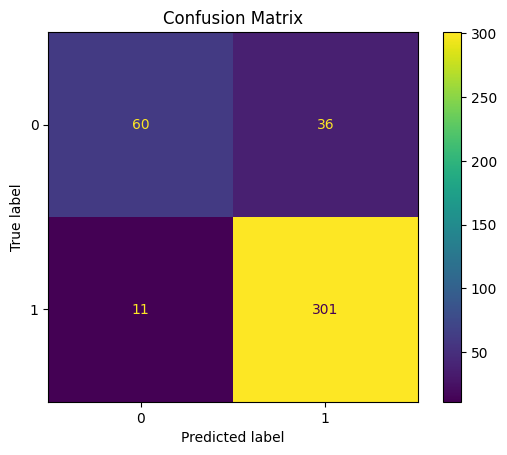

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_test and y_pred are numpy arrays or lists of 0/1 labels
cm = confusion_matrix(y_test, y_pred.numpy())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

plt.title("Confusion Matrix")
plt.show()